In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jul  9 19:08:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   32C    P8    23W / 250W |   6591MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   62C    P0   159W / 250W |  11185MiB / 16280MiB |     81%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import SimpleCNN5Layer_Ca as Model
from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 200, 1e-3, 217)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 10.44 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 10.23 s
Loaded /share/lazy/will/ML_mdsA/June30_2020_80k_1.h5 in 10.11 s
Loaded /share/lazy/will/ML_mdsA/June30_2020_80k_3.h5 in 10.15 s
Constructing 320000 event dataset took 6.201 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.519 s
Constructing 9984 event dataset took 0.06104 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelD()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

path = 'run_stats.pyt'
load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/d4c36a4ce6a24fa084bf844256bee04f/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

Of the 37 parameter layers to update in the current model, 10 were loaded
Of the 37 parameter layers to update in the current model, 10 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_D(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(10, eps=1e-05, 

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


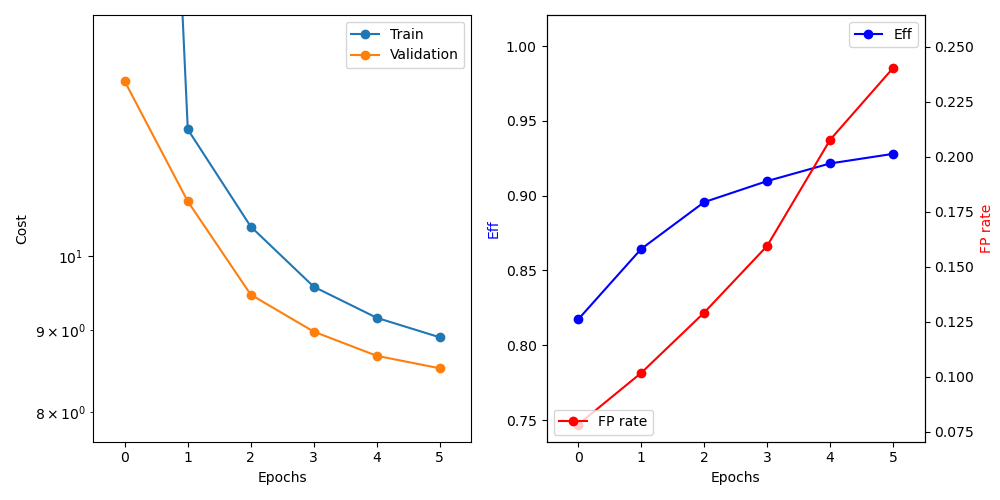

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

In [ ]:
print('for model: ', model)   
run_name = 'SCNN to ACNN 2'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
        xs = results.index

        # Update the plot above
        lines['train'].set_data(results.index, results.cost)
        lines['val'].set_data(results.index, results.val)

        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
        plt.tight_layout()
        fig.savefig('plot.png')
            
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
        HL.transforms.Fold("Conv", "Conv"),
        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
        # save plot
        mlflow.log_artifact('plot.png')

for model:  All_CNN6Layer_D(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(10,

/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 217: train=86.6124, val=12.855, took 76.506 s
  Validation Found 44544 of 54504, added 781 (eff 81.73%) (0.0782 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 218: train=12.0005, val=10.8228, took 75.54 s
  Validation Found 47112 of 54504, added 1015 (eff 86.44%) (0.102 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 219: train=10.4369, val=9.46603, took 75.704 s
  Validation Found 48818 of 54504, added 1289 (eff 89.57%) (0.129 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 220: train=9.57438, val=8.97707, took 75.697 s
  Validation Found 49586 of 54504, added 1592 (eff 90.98%) (0.159 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 221: train=9.15703, val=8.67101, took 75.56 s
  Validation Found 50228 of 54504, added 2074 (eff 92.15%) (0.208 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 222: train=8.9045, val=8.51744, took 76.878 s
  Validation Found 50578 of 54504, added 2400 (eff 92.80%) (0.24 FP/event)


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:143: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


In [ ]:
##quit()